In [1]:
# import dependencies 1

import os

path_to_dir = '/kaggle/input/cifar10-batches'
for dirname, _, filenames in os.walk(path_to_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cifar10-batches/cifar10-batches/data_batch_1
/kaggle/input/cifar10-batches/cifar10-batches/data_batch_2
/kaggle/input/cifar10-batches/cifar10-batches/batches.meta
/kaggle/input/cifar10-batches/cifar10-batches/test_batch
/kaggle/input/cifar10-batches/cifar10-batches/data_batch_3
/kaggle/input/cifar10-batches/cifar10-batches/data_batch_5
/kaggle/input/cifar10-batches/cifar10-batches/data_batch_4
/kaggle/input/cifar10-batches/cifar10-batches/readme.html


In [2]:
# import dependencies 2

import numpy as np
import tensorflow as tf

print(tf.__version__)

print("--> Checking for physical Tensorflow devices")
for gpu_device in tf.config.list_physical_devices('GPU'):
    print(": {}".format(gpu_device.name))
    tf.config.experimental.set_memory_growth(gpu_device, True)

2.6.2
--> Checking for physical Tensorflow devices
: /physical_device:GPU:0


2022-02-27 17:01:34.286526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 17:01:34.296040: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 17:01:34.296723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
!pip install adabelief-tf

In [4]:
# import dependencies 3

from tensorflow import keras

from keras import backend as K

from tensorflow.keras import optimizers as opt
from tensorflow_addons.optimizers import SGDW, AdamW
from adabelief_tf import AdaBeliefOptimizer

from keras.utils import np_utils

from tensorflow.keras.applications import DenseNet121

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

import pickle
import sys

In [5]:
# helper functions

def load_batch(f_path, label_key='labels'):
    
    with open(f_path, 'rb') as f:
        d = pickle.load(f, encoding='bytes')
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode('utf8')] = v
        d = d_decoded
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def load_data(path):

    num_train_samples = 50000
    num_batch_samples = 10000

    x_train_local = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train_local = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        f_path = os.path.join(path, 'data_batch_' + str(i))
        (x_train_local[(i - 1) * num_batch_samples: i * num_batch_samples, :, :, :],
         y_train_local[(i - 1) * num_batch_samples: i * num_batch_samples]) = load_batch(f_path)

    f_path = os.path.join(path, 'test_batch')
    x_test_local, y_test_local = load_batch(f_path)

    y_train_local = np.reshape(y_train_local, (len(y_train_local), 1))
    y_test_local = np.reshape(y_test_local, (len(y_test_local), 1))
        
    if K.image_data_format() == 'channels_last':
        x_train_local = x_train_local.transpose(0, 2, 3, 1)
        x_test_local = x_test_local.transpose(0, 2, 3, 1)

    return (x_train_local, y_train_local), (x_test_local, y_test_local)


def load_labels(path):
    
    f_path = os.path.join(path, 'batches.meta')
    with open(f_path, 'rb') as f:
        labels_bytes = pickle.load(f, encoding = 'bytes')
        labels_decoded = {}
        for k, v in labels_bytes.items():
            labels_decoded[k.decode('utf8')] = v
        labels_bytes = labels_decoded
        
    labels = labels_bytes['label_names']
    
    return labels

In [6]:
# HYPERPARAMETERS
batch_size = 128
epochs = 200

# global variables
cifar10 = os.path.join(path_to_dir, 'cifar10-batches')
save_dir = os.path.join(os.getcwd(), 'models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

# sgd model path
model_sgd_name = 'sgd_cifar10_{}.h5'.format(epochs)
model_sgd_path = os.path.join(save_dir, model_sgd_name)

# adabelief model path
model_ada_name = 'adabelief_cifar10_{}.h5'.format(epochs)
model_ada_path = os.path.join(save_dir, model_ada_name)

# adam model path
model_adam_name = 'adam_cifar10_{}.h5'.format(epochs)
model_adam_path = os.path.join(save_dir, model_adam_name)

# custom learning rate
initial_learning_rate = 1e-3
step = tf.Variable(0, trainable = False)
boundaries = [int(epochs * 0.75)]
values = [initial_learning_rate, initial_learning_rate * 0.1]

2022-02-27 17:01:42.398731: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-27 17:01:42.399277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 17:01:42.400175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 17:01:42.400931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [7]:
# load data and labels
(x_train, y_train), (x_test, y_test) = load_data(cifar10)
labels = load_labels(cifar10)

# apply train-val split to have some unseen data for the final assessment
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, shuffle = True)

# scale dataset in range [-1, +1]
x_train = 2 * (x_train.astype('float32') / 255) - 1
x_test = 2 * (x_test.astype('float32') / 255) - 1
x_val = 2 * (x_val.astype('float32') / 255) - 1

print("Train data (x_train): ", x_train.shape)
print("Train labels (y_train): ", y_train.shape)
print("Test data (x_test): ", x_test.shape)
print("Test labels (y_test): ", y_test.shape)
print("Val data (x_val): ", x_val.shape)
print("Val labels (y_val):", y_val.shape)

# 1) take unique values inside a flattened np.array, 
# 2) put them in a list, 
# 3) return the length of that list
classes_set = set(y_test.flatten())
classes = list(classes_set)
num_classes = len(list(classes_set))

print("Length of classes list:", num_classes)

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes, dtype = 'float32')
y_test = np_utils.to_categorical(y_test, num_classes, dtype = 'float32')
y_val = np_utils.to_categorical(y_val, num_classes, dtype = 'float32')

# initialize learning rates and optimizers
learning_rate_fn = opt.schedules.PiecewiseConstantDecay(boundaries, values)
opt_sgd = SGDW(learning_rate = learning_rate_fn(step), momentum = 0.9, weight_decay = 5e-4)
opt_ada = AdaBeliefOptimizer(learning_rate = learning_rate_fn(step), epsilon = 1e-8, weight_decay = 5e-4)
opt_adam = AdamW(learning_rate = learning_rate_fn(step), epsilon = 1e-8, weight_decay = 5e-4)

Train data (x_train):  (45000, 32, 32, 3)
Train labels (y_train):  (45000, 1)
Test data (x_test):  (10000, 32, 32, 3)
Test labels (y_test):  (10000, 1)
Val data (x_val):  (5000, 32, 32, 3)
Val labels (y_val): (5000, 1)
Length of classes list: 10
Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
>=0.1.0 (Current 0.2.1)  1e-14  supported          default: True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended epsilon = 1e-7                                  Recommended epsilon = 1e-14
For a complete table of recommended hyperparameters, see
https://github.com/juntan

In [8]:
# initialize adabelief-based network
model_ada = DenseNet121(include_top = True,
                weights = None,
                classes = num_classes, 
                input_shape = x_train.shape[1:])

# compile adabelief-based network
model_ada.compile(loss = 'categorical_crossentropy',
                 optimizer = opt_ada,
                 metrics = ['mae', 'accuracy'])

In [9]:
# train adabelief-based network
with tf.device('/GPU:0'):
    history_ada = model_ada.fit(x_train, y_train, 
                                batch_size = batch_size, 
                                epochs = epochs, 
                                validation_data = (x_test, y_test), 
                                shuffle = True,
                                verbose = 2)

2022-02-27 17:01:47.122910: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-02-27 17:02:48.014347: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


352/352 - 126s - loss: 1.7049 - mae: 0.1447 - accuracy: 0.3810 - val_loss: 2.6648 - val_mae: 0.1594 - val_accuracy: 0.2327
Epoch 2/200
352/352 - 62s - loss: 1.2829 - mae: 0.1161 - accuracy: 0.5348 - val_loss: 1.4101 - val_mae: 0.1213 - val_accuracy: 0.4986
Epoch 3/200
352/352 - 60s - loss: 1.0639 - mae: 0.0988 - accuracy: 0.6213 - val_loss: 1.1402 - val_mae: 0.1001 - val_accuracy: 0.6037
Epoch 4/200
352/352 - 60s - loss: 0.9065 - mae: 0.0851 - accuracy: 0.6774 - val_loss: 1.0792 - val_mae: 0.0938 - val_accuracy: 0.6197
Epoch 5/200
352/352 - 61s - loss: 0.7721 - mae: 0.0739 - accuracy: 0.7262 - val_loss: 1.0067 - val_mae: 0.0873 - val_accuracy: 0.6460
Epoch 6/200
352/352 - 62s - loss: 0.6653 - mae: 0.0644 - accuracy: 0.7634 - val_loss: 1.0420 - val_mae: 0.0804 - val_accuracy: 0.6577
Epoch 7/200
352/352 - 62s - loss: 0.5680 - mae: 0.0559 - accuracy: 0.7979 - val_loss: 1.0429 - val_mae: 0.0774 - val_accuracy: 0.6611
Epoch 8/200
352/352 - 61s - loss: 0.4983 - mae: 0.0496 - accuracy: 0.8220

In [10]:
# save model and weights
model_ada.save(model_ada_path)
print('Saved ADA model at %s ' % model_ada_path)

Saved ADA model at /kaggle/working/models/adabelief_cifar10_200.h5 


In [11]:
# initialize sgd-based network
model_sgd = DenseNet121(include_top = True,
                weights = None,
                classes = num_classes, 
                input_shape = x_train.shape[1:])

# compile sgd-based network
model_sgd.compile(loss = 'categorical_crossentropy',
                 optimizer = opt_sgd,
                 metrics = ['mae', 'accuracy'])

In [12]:
# train sgd-based network
with tf.device('/GPU:0'):    
    history_sgd = model_sgd.fit(x_train, y_train, 
                               batch_size = batch_size,
                               epochs = epochs, 
                               validation_data = (x_test, y_test), 
                               shuffle = True,
                               verbose = 2)

Epoch 1/200
352/352 - 38s - loss: 1.8064 - mae: 0.1541 - accuracy: 0.3398 - val_loss: 2.2756 - val_mae: 0.1750 - val_accuracy: 0.1651
Epoch 2/200
352/352 - 26s - loss: 1.4505 - mae: 0.1348 - accuracy: 0.4724 - val_loss: 1.9235 - val_mae: 0.1632 - val_accuracy: 0.3292
Epoch 3/200
352/352 - 26s - loss: 1.2802 - mae: 0.1223 - accuracy: 0.5428 - val_loss: 1.8139 - val_mae: 0.1595 - val_accuracy: 0.3705
Epoch 4/200
352/352 - 26s - loss: 1.1618 - mae: 0.1130 - accuracy: 0.5913 - val_loss: 1.6962 - val_mae: 0.1545 - val_accuracy: 0.4278
Epoch 5/200
352/352 - 26s - loss: 1.0613 - mae: 0.1050 - accuracy: 0.6344 - val_loss: 1.6462 - val_mae: 0.1511 - val_accuracy: 0.4378
Epoch 6/200
352/352 - 26s - loss: 0.9772 - mae: 0.0978 - accuracy: 0.6680 - val_loss: 1.6741 - val_mae: 0.1493 - val_accuracy: 0.4201
Epoch 7/200
352/352 - 25s - loss: 0.9166 - mae: 0.0927 - accuracy: 0.6970 - val_loss: 1.5092 - val_mae: 0.1425 - val_accuracy: 0.4928
Epoch 8/200
352/352 - 26s - loss: 0.8636 - mae: 0.0886 - accur

In [13]:
# save model and weights
model_sgd.save(model_sgd_path)
print('Saved SGD model at %s ' % model_sgd_path)

Saved SGD model at /kaggle/working/models/sgd_cifar10_200.h5 


In [14]:
# initialize adam-based network
model_adam = DenseNet121(include_top = True,
                weights = None,
                classes = num_classes, 
                input_shape = x_train.shape[1:])

# compile adam-based network
model_adam.compile(loss = 'categorical_crossentropy',
                  optimizer = opt_adam,
                  metrics = ['mae', 'accuracy'])

In [15]:
# train adam-based network
with tf.device('/GPU:0'):  
    history_adam = model_adam.fit(x_train, y_train, 
                                batch_size = batch_size, 
                                epochs = epochs, 
                                validation_data = (x_test, y_test), 
                                shuffle = True,
                                verbose = 2
                            )

Epoch 1/200
352/352 - 42s - loss: 1.4532 - mae: 0.1287 - accuracy: 0.4772 - val_loss: 2.1641 - val_mae: 0.1583 - val_accuracy: 0.2842
Epoch 2/200
352/352 - 28s - loss: 1.0618 - mae: 0.0991 - accuracy: 0.6228 - val_loss: 1.1755 - val_mae: 0.1149 - val_accuracy: 0.5842
Epoch 3/200
352/352 - 28s - loss: 0.8733 - mae: 0.0834 - accuracy: 0.6932 - val_loss: 1.1373 - val_mae: 0.1062 - val_accuracy: 0.6028
Epoch 4/200
352/352 - 29s - loss: 0.7637 - mae: 0.0737 - accuracy: 0.7328 - val_loss: 0.9869 - val_mae: 0.0964 - val_accuracy: 0.6520
Epoch 5/200
352/352 - 28s - loss: 0.6964 - mae: 0.0676 - accuracy: 0.7573 - val_loss: 1.0381 - val_mae: 0.0943 - val_accuracy: 0.6240
Epoch 6/200
352/352 - 28s - loss: 0.6303 - mae: 0.0617 - accuracy: 0.7819 - val_loss: 0.8495 - val_mae: 0.0857 - val_accuracy: 0.7092
Epoch 7/200
352/352 - 28s - loss: 0.5881 - mae: 0.0579 - accuracy: 0.7972 - val_loss: 1.0526 - val_mae: 0.0918 - val_accuracy: 0.6255
Epoch 8/200
352/352 - 27s - loss: 0.5465 - mae: 0.0539 - accur

In [16]:
# save model and weights
model_adam.save(model_adam_path)
print('Saved ADAM model at %s ' % model_adam_path)

Saved ADAM model at /kaggle/working/models/adam_cifar10_200.h5 


In [17]:
# load models for inference
ada_model = keras.models.load_model(model_ada_path, compile = False)
sgd_model = keras.models.load_model(model_sgd_path, compile = False)
adam_model = keras.models.load_model(model_adam_path, compile = False)

"""
# print shapes and weights
print("model shapes:")
ada_model.summary()

print("weights shapes:")
for layer in loaded_model.layers:
    print(layer.name)
    if (len(layer.get_weights()) != 0):
        for i in range(len(layer.get_weights())):
            print(layer.get_weights()[i].shape)
"""

'\n# print shapes and weights\nprint("model shapes:")\nada_model.summary()\n\nprint("weights shapes:")\nfor layer in loaded_model.layers:\n    print(layer.name)\n    if (len(layer.get_weights()) != 0):\n        for i in range(len(layer.get_weights())):\n            print(layer.get_weights()[i].shape)\n'

In [18]:
# apply prediction on test set
y_pred_ada = ada_model.predict(x_val)
y_pred_sgd = sgd_model.predict(x_val)
y_pred_adam = adam_model.predict(x_val)

In [19]:
# print performance metrics
cm_ada = confusion_matrix(y_val.argmax(axis = 1), y_pred_ada.argmax(axis = 1))
cm_sgd = confusion_matrix(y_val.argmax(axis = 1), y_pred_sgd.argmax(axis = 1))
cm_adam = confusion_matrix(y_val.argmax(axis = 1), y_pred_adam.argmax(axis = 1))
print('Confusion matrix for adabelief:\n{}\nConfusion matrix for sgd:\n{}\nConfusion matrix for adam:\n{}\n'.format(cm_ada, cm_sgd, cm_adam))
acc_ada = accuracy_score(y_val.argmax(axis = 1), y_pred_ada.argmax(axis = 1))
acc_sgd = accuracy_score(y_val.argmax(axis = 1), y_pred_sgd.argmax(axis = 1))
acc_adam = accuracy_score(y_val.argmax(axis = 1), y_pred_adam.argmax(axis = 1))
print('accuracy score for adabelief: {}\naccuracy score for sgd: {}\naccuracy score for adam: {}'.format(acc_ada, acc_sgd, acc_adam))

Confusion matrix for adabelief:
[[408   9  22   7   9   5   5   3  24  11]
 [  5 443   2   5   0   0   3   0   8  22]
 [ 31   3 392  32  40  18  12   6   5   3]
 [ 10   2  34 333  27  66  22  15   6   7]
 [  6   2  26  25 378  11   9  18   5   0]
 [  4   4  21  81  21 318  14  24   6   3]
 [  3   4  16  25   9  16 408   1   3   3]
 [ 10   0   8  16  19  18   2 427   0   2]
 [ 19  14   3   5   1   0   1   2 444  11]
 [ 12  37   2   9   3   3   1   2   9 401]]
Confusion matrix for sgd:
[[151  14  11 136   2   9  13  11  68  88]
 [  2 427   0   9   0   0   3   0   5  42]
 [ 10   5 287 144   5  38  28  10   3  12]
 [  0   2   8 445   0  36   8   5   2  16]
 [  1   2  21 175 210  18  11  30   2  10]
 [  0   3   2 209   2 262   3  11   2   2]
 [  0   2   4 104   0  19 351   0   6   2]
 [  0   4   3  90   8  16   2 365   0  14]
 [  2  24   2  34   0   0   9   0 396  33]
 [  0  17   1   9   0   0   3   1   4 444]]
Confusion matrix for adam:
[[457   2   4   0   2   2   0   0  35   1]
 [ 43 356 

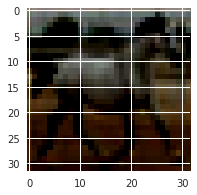

prediction of image, according to adabelief, is: b'horse'


In [20]:
# visualization of one image and relative prediction
index = int(np.random.uniform(0, x_val.shape[0]))
x_rand = x_val[index]

plt.figure(figsize = (3, 3))
plt.imshow(x_rand)
plt.show()

x_rand = np.expand_dims(x_rand, axis = 0)
y_rand = ada_model.predict(x_rand)

l = y_rand.argmax(axis = 1).item()
print("prediction of image, according to adabelief, is: {}".format(labels[l]))

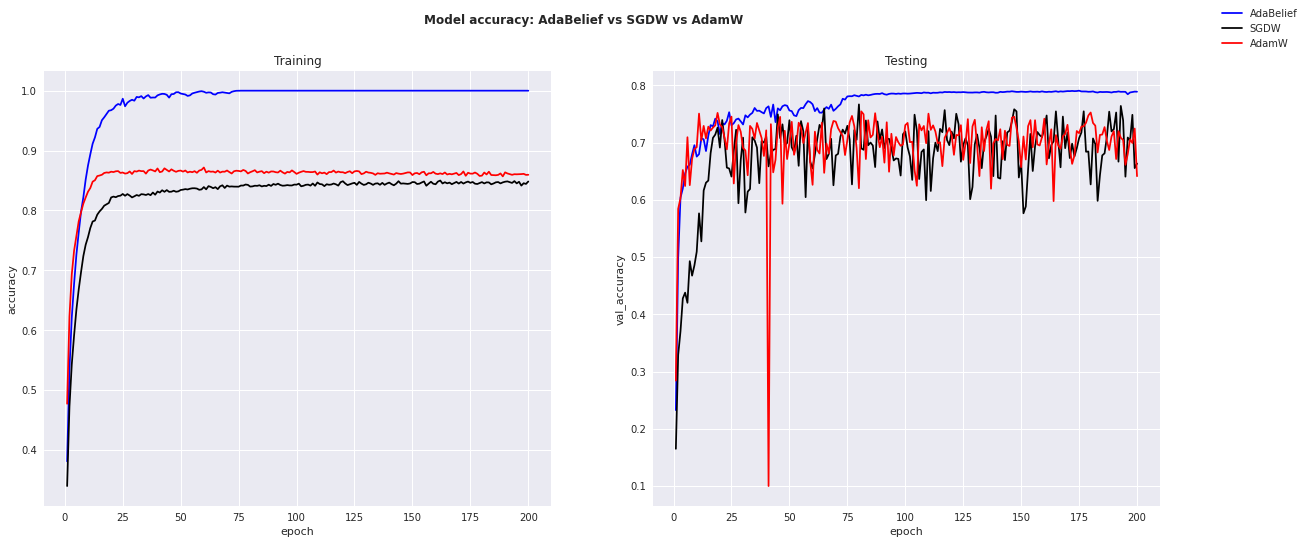

In [21]:
# accuracy plot
fig = plt.figure(figsize = (20, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
x_axis = np.linspace(1, epochs, epochs)

ax1.plot(x_axis, history_ada.history['accuracy'], color = 'blue')
ax1.plot(x_axis, history_sgd.history['accuracy'], color = 'black')
ax1.plot(x_axis, history_adam.history['accuracy'], color = 'red')
ax1.title.set_text('Training')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax2.plot(x_axis, history_ada.history['val_accuracy'], color = 'blue')
ax2.plot(x_axis, history_sgd.history['val_accuracy'], color = 'black')
ax2.plot(x_axis, history_adam.history['val_accuracy'], color = 'red')
ax2.title.set_text('Testing')
ax2.set_xlabel('epoch')
ax2.set_ylabel('val_accuracy')

fig.legend(['AdaBelief', 'SGDW', 'AdamW'])
plt.suptitle('Model accuracy: AdaBelief vs SGDW vs AdamW', weight = 'bold')
plt.show()

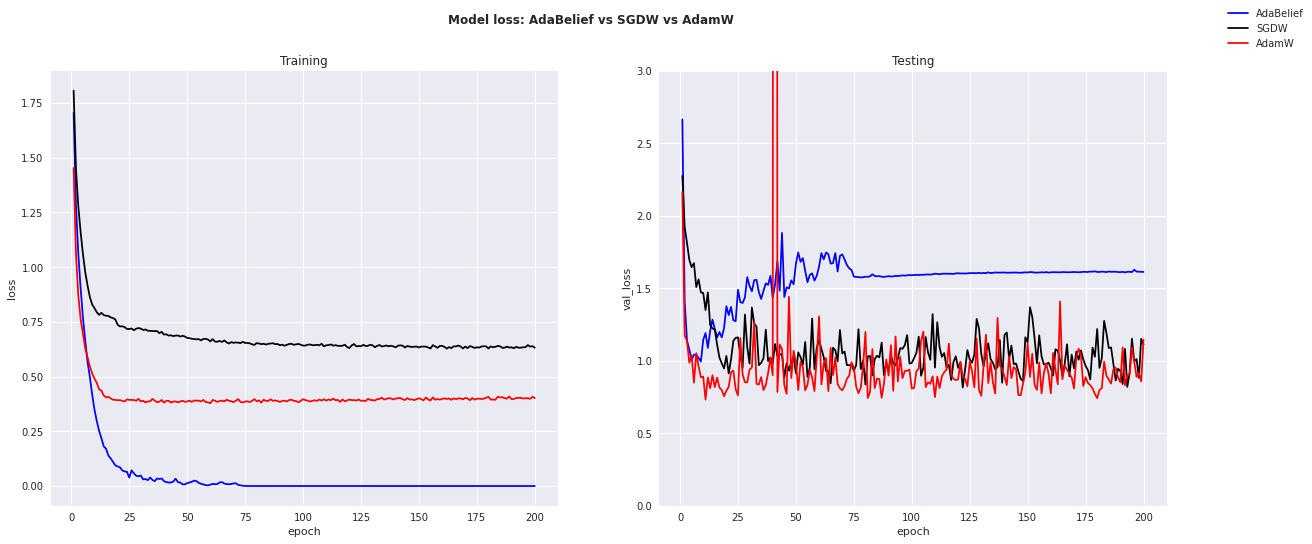

In [25]:
# loss function plot
fig = plt.figure(figsize = (20, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
x_axis = np.linspace(1, epochs, epochs)

ax1.plot(x_axis, history_ada.history['loss'], color = 'blue')
ax1.plot(x_axis, history_sgd.history['loss'], color = 'black')
ax1.plot(x_axis, history_adam.history['loss'], color = 'red')
ax1.title.set_text('Training')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')

ax2.plot(x_axis, history_ada.history['val_loss'], color = 'blue')
ax2.plot(x_axis, history_sgd.history['val_loss'], color = 'black')
ax2.plot(x_axis, history_adam.history['val_loss'], color = 'red')
ax2.title.set_text('Testing')
ax2.set_xlabel('epoch')
ax2.set_ylabel('val_loss')
ax2.set_ylim(0, 3)

fig.legend(['AdaBelief', 'SGDW', 'AdamW'])
plt.suptitle('Model loss: AdaBelief vs SGDW vs AdamW', weight = 'bold')
plt.show()